In [1]:
import numpy as np
import cv2 # openCV
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]=[12,8]

# check the opencv version
print(cv2.__version__)

4.10.0


In [2]:
import requests
url = 'https://raw.githubusercontent.com/Masterx-AI/Project_Object_Detection_Yolo_V4/main/people_bicycles.jpg'
r = requests.get(url, allow_redirects=True)
open('people_bicycles.jpg', 'wb').write(r.content)

72647

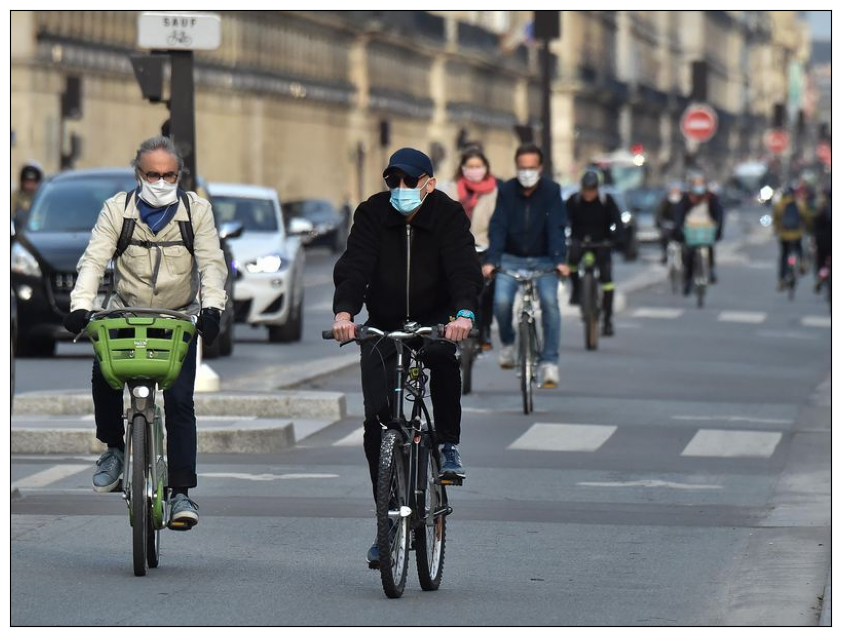

In [3]:
# Reading the image file
test_img = cv2.imread('people_bicycles.jpg')
img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Plotting the image
def plot_image(img, cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    
plot_image(img)
plt.show()

In [8]:
import os

# create folder
os.makedirs("model", exist_ok=True)
os.chdir("model")

# download using curl
!curl -L -o yolov4.weights https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
!curl -L -o yolov4.cfg https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg
!curl -L -o coco.names https://raw.githubusercontent.com/AlexeyAB/darknet/master/data/coco.names

os.chdir("..")


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0  245M    0 39766    0     0  23413      0  3:03:27  0:00:01  3:03:26 23413
  0  245M    0  572k    0     0   238k      0  0:17:33  0:00:02  0:17:31  765k
  2  245M    2 7132k    0     0  2015k      0  0:02:04  0:00:03  0:02:01 3853k
  4  245M    4 11.2M    0     0  2633k      0  0:01:35  0:00:04  0:01:31 4297k
  6  245M    6 15.7M    0     0  3013k      0  0:01:23  0:00:05  0:01:18 4399k
  8  245M    8 20.3M    0     0  3274k      0  0:01:16  0:00:06  0:01:10 4459k
 10  245M   10 25.6M    0     0  3566k      0  0:01:10  0:00:07  0:01:03 5171k
 12  245M   12 30.0M    0     0  3643k      0  0:0

In [5]:
# Converting to blob object

scalefactor = 1.0/255.0
new_size = (416, 416)
blob = cv2.dnn.blobFromImage(test_img, scalefactor, new_size, swapRB=True, crop=False)

In [9]:
# define class labels
class_labels_path = "model/coco.names"
class_labels = open(class_labels_path).read().strip().split("\n")
class_labels

# declare repeating bounding box colors for each class 
# 1st: create a list colors as an RGB string array
# Example: Red, Green, Blue, Yellow, Magenda
class_colors = ["255,0,0","0,255,0","0,0,255","255,155,0","255,0, 255"]
 
#2nd: split the array on comma-separated strings and for change each string type to integer
class_colors = [np.array(every_color.split(",")).astype("int") for every_color in class_colors]
 
#3rd: convert the array or arrays to a numpy array
class_colors = np.array(class_colors)
 
#4th: tile this to get 80 class colors, i.e. as many as the classes(16 rows of 5cols each). 
# If you want unique colors for each class you may randomize the color generation or set them manually
class_colors = np.tile(class_colors,(16,1))

def colored(r, g, b, text):
    return "\033[38;2;{};{};{}m{} \033[38;2;255;255;255m".format(r, g, b, text)
 
for i in range(16):
    line = ""
    for j in range(5):
        class_id = i*5 + j
        class_id_str = str(class_id)
        text = "class" + class_id_str
        colored_text = colored(class_colors[class_id][0], class_colors[class_id][1], class_colors[class_id][2], text)
        line += colored_text
    print(line)

# or select the colors randomly
class_colors = np.random.randint(0, 255, size=(len(class_labels), 3), dtype="uint8")

class0 class1 class2 class3 class4 
class5 class6 class7 class8 class9 
class10 class11 class12 class13 class14 
class15 class16 class17 class18 class19 
class20 class21 class22 class23 class24 
class25 class26 class27 class28 class29 
class30 class31 class32 class33 class34 
class35 class36 class37 class38 class39 
class40 class41 class42 class43 class44 
class45 class46 class47 class48 class49 
class50 class51 class52 class53 class54 
class55 class56 class57 class58 class59 
class60 class61 class62 class63 class64 
class65 class66 class67 class68 class69 
class70 class71 class72 class73 class74 
class75 class76 class77 class78 class79 


In [10]:
# Load the pre-trained model 
yolo_model = cv2.dnn.readNetFromDarknet('model/yolov4.cfg','model/yolov4.weights')

# Read the network layers/components. The YOLO V4 neural network has 379 components. They consist of convolutional layers (conv), rectifier linear units (relu) etc.:
model_layers = yolo_model.getLayerNames()
print("number of network components: " + str(len(model_layers))) 
# print(model_layers)

# extract the output layers in the code that follows:
# - model_layer[0]: returns the index of each output layer in the range of 1 to 379
# - model_layer[0] - 1: corrects  this to the range of 0 to 378
# - model_layers[model_layer[0] - 1]: returns the indexed layer name 
output_layers = [model_layers[model_layer - 1] for model_layer in yolo_model.getUnconnectedOutLayers()]
 
# YOLOv4 deploys the same YOLO head as YOLOv3 for detection with the anchor based detection steps, and three levels of detection granularity. 
print(output_layers)

number of network components: 379
['yolo_139', 'yolo_150', 'yolo_161']


In [11]:
# input pre-processed blob into the model
yolo_model.setInput(blob)
 
# compute the forward pass for the input, storing the results per output layer in a list
obj_detections_in_layers = yolo_model.forward(output_layers)
 
# verify the number of sets of detections
print("number of sets of detections: " + str(len(obj_detections_in_layers)))

number of sets of detections: 3


predicted object traffic light: 56.24%
predicted object traffic light: 56.25%
predicted object traffic light: 52.78%
predicted object traffic light: 33.06%
predicted object traffic light: 31.07%
predicted object traffic light: 30.06%
predicted object traffic light: 34.51%
predicted object traffic light: 34.09%
predicted object traffic light: 27.52%
predicted object traffic light: 23.15%
predicted object traffic light: 22.80%
predicted object stop sign: 43.93%
predicted object stop sign: 43.61%
predicted object stop sign: 41.78%
predicted object person: 24.01%
predicted object person: 23.02%
predicted object car: 20.48%
predicted object car: 20.05%
predicted object person: 42.55%
predicted object person: 39.85%
predicted object person: 21.27%
predicted object person: 20.06%
predicted object person: 38.13%
predicted object person: 36.41%
predicted object car: 35.70%
predicted object car: 36.26%
predicted object backpack: 26.10%
predicted object backpack: 27.40%
predicted object car: 75.5

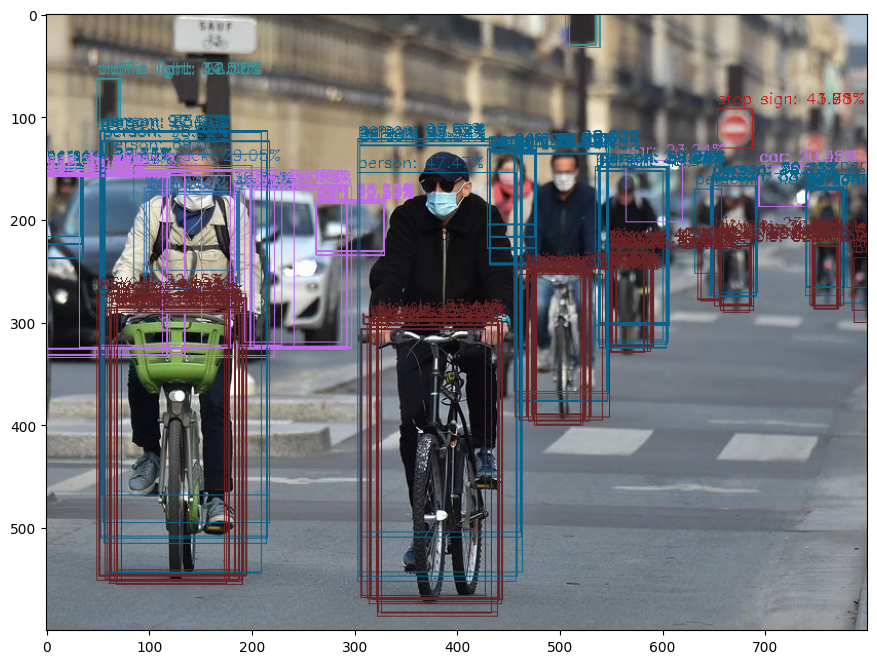

In [12]:
def object_detection_analysis(test_image, obj_detections_in_layers, confidence_threshold): 
 
  # get the image dimensions  
  img_height = test_img.shape[0]
  img_width = test_img.shape[1]
 
  result = test_image.copy()
  
  # loop over each output layer 
  for object_detections_in_single_layer in obj_detections_in_layers:
    # loop over the detections in each layer
      for object_detection in object_detections_in_single_layer:  
        # obj_detection[1]: bbox center pt_x
        # obj_detection[2]: bbox center pt_y
        # obj_detection[3]: bbox width
        # obj_detection[4]: bbox height
        # obj_detection[5]: confidence scores for all detections within the bbox 
 
        # get the confidence scores of all objects detected with the bounding box
        prediction_scores = object_detection[5:]
        # consider the highest score being associated with the winning class
        # get the class ID from the index of the highest score 
        predicted_class_id = np.argmax(prediction_scores)
        # get the prediction confidence
        prediction_confidence = prediction_scores[predicted_class_id]
    
        # consider object detections with confidence score higher than threshold
        if prediction_confidence > confidence_threshold:
            # get the predicted label
            predicted_class_label = class_labels[predicted_class_id]
            # compute the bounding box coordinates scaled for the input image 
            # scaling is a multiplication of the float coordinate with the appropriate  image dimension
            bounding_box = object_detection[0:4] * np.array([img_width, img_height, img_width, img_height])
            # get the bounding box centroid (x,y), width and height as integers
            (box_center_x_pt, box_center_y_pt, box_width, box_height) = bounding_box.astype("int")
            # to get the start x and y coordinates we to subtract from the centroid half the width and half the height respectively 
            # for even values of width and height of bboxes adjacent to the  image border
            #  this may generate a -1 which is prevented by the max() operator below  
            start_x_pt = max(0, int(box_center_x_pt - (box_width / 2)))
            start_y_pt = max(0, int(box_center_y_pt - (box_height / 2)))
            end_x_pt = start_x_pt + box_width
            end_y_pt = start_y_pt + box_height
            
            # get a random mask color from the numpy array of colors
            box_color = class_colors[predicted_class_id]
            
            # convert the color numpy array as a list and apply to text and box
            box_color = [int(c) for c in box_color]
            
            # print the prediction in console
            predicted_class_label = "{}: {:.2f}%".format(predicted_class_label, prediction_confidence * 100)
            print("predicted object {}".format(predicted_class_label))
            
            # draw the rectangle and text in the image
            cv2.rectangle(result, (start_x_pt, start_y_pt), (end_x_pt, end_y_pt), box_color, 1)
            cv2.putText(result, predicted_class_label, (start_x_pt, start_y_pt-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 1)
  return result
 
confidence_threshold = 0.2
result_raw = object_detection_analysis(test_img, obj_detections_in_layers, confidence_threshold)
 
result_img = cv2.cvtColor(result_raw, cv2.COLOR_BGR2RGB)
plt.imshow(result_img)
plt.show()

In [13]:
class_ids_list = []
boxes_list = []
confidences_list = []

In [14]:
def object_detection_attributes(test_image, obj_detections_in_layers, confidence_threshold):
  # get the image dimensions  
  img_height = test_img.shape[0]
  img_width = test_img.shape[1]
  
  # loop over each output layer 
  for object_detections_in_single_layer in obj_detections_in_layers:
    # loop over the detections in each layer
    for object_detection in object_detections_in_single_layer:  
      # get the confidence scores of all objects detected with the bounding box
      prediction_scores = object_detection[5:]
      # consider the highest score being associated with the winning class
      # get the class ID from the index of the highest score 
      predicted_class_id = np.argmax(prediction_scores)
      # get the prediction confidence
      prediction_confidence = prediction_scores[predicted_class_id]
      
      # consider object detections with confidence score higher than threshold
      if prediction_confidence > confidence_threshold:
        # get the predicted label
        predicted_class_label = class_labels[predicted_class_id]
        # compute the bounding box coordinates scaled for the input image
        bounding_box = object_detection[0:4] * np.array([img_width, img_height, img_width, img_height])
        (box_center_x_pt, box_center_y_pt, box_width, box_height) = bounding_box.astype("int")
        start_x_pt = max(0, int(box_center_x_pt - (box_width / 2)))
        start_y_pt = max(0, int(box_center_y_pt - (box_height / 2)))
        
        # update the 3 lists for nms processing
        # - confidence is needed as a float 
        # - the bbox info has the openCV Rect format
        class_ids_list.append(predicted_class_id)
        confidences_list.append(float(prediction_confidence))
        boxes_list.append([int(start_x_pt), int(start_y_pt), int(box_width), int(box_height)])

In [15]:
score_threshold = 0.5
object_detection_attributes(test_img, obj_detections_in_layers, score_threshold)

predicted object person: 99.03%
predicted object person: 98.98%
predicted object person: 98.02%
predicted object person: 97.04%
predicted object car: 94.08%
predicted object person: 92.78%
predicted object bicycle: 88.47%
predicted object bicycle: 85.44%
predicted object car: 82.24%
predicted object person: 81.44%
predicted object car: 73.61%
predicted object bicycle: 71.95%
predicted object bicycle: 68.52%
predicted object bicycle: 62.42%
predicted object bicycle: 57.65%
predicted object traffic light: 56.25%
predicted object bicycle: 53.34%
predicted object person: 51.23%


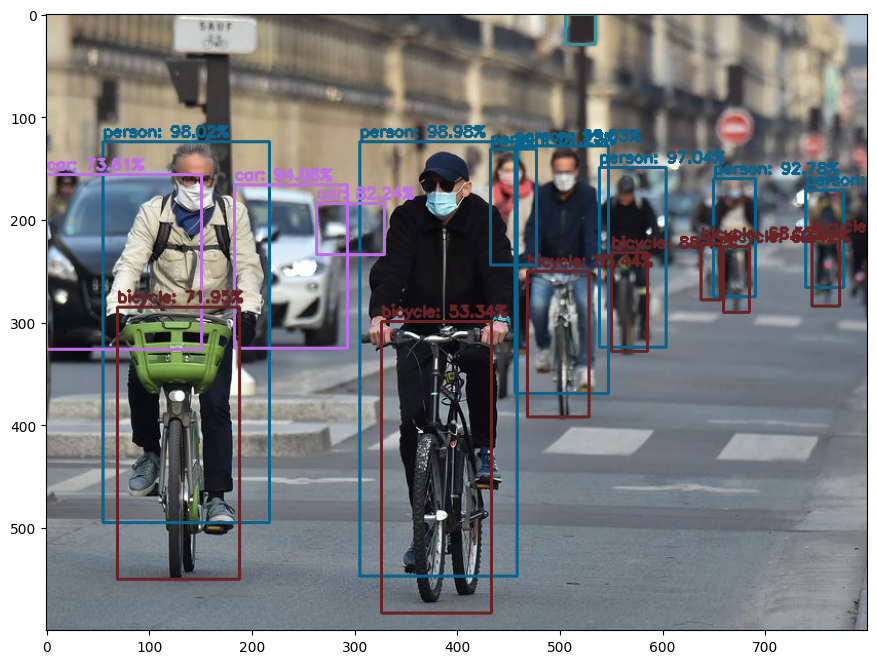

In [16]:
# NMS for a set of overlapping bboxes returns the ID of the one with highest 
# confidence score while suppressing all others (non maxima)
# - score_threshold: a threshold used to filter boxes by score 
# - nms_threshold: a threshold used in non maximum suppression. 
 
score_threshold = 0.5
nms_threshold = 0.4
winner_ids = cv2.dnn.NMSBoxes(boxes_list, confidences_list, score_threshold, nms_threshold)

# loop through the final set of detections remaining after NMS and draw bounding box and write text
for winner_id in winner_ids:
    max_class_id = winner_id
    box = boxes_list[max_class_id]
    start_x_pt = box[0]
    start_y_pt = box[1]
    box_width = box[2]
    box_height = box[3]
    
    #get the predicted class id and label
    predicted_class_id = class_ids_list[max_class_id]
    predicted_class_label = class_labels[predicted_class_id]
    prediction_confidence = confidences_list[max_class_id]
 
    #obtain the bounding box end coordinates
    end_x_pt = start_x_pt + box_width
    end_y_pt = start_y_pt + box_height
    
    #get a random mask color from the numpy array of colors
    box_color = class_colors[predicted_class_id]
    
    #convert the color numpy array as a list and apply to text and box
    box_color = [int(c) for c in box_color]
    
    # print the prediction in console
    predicted_class_label = "{}: {:.2f}%".format(predicted_class_label, prediction_confidence * 100)
    print("predicted object {}".format(predicted_class_label))
    
    # draw rectangle and text in the image
    cv2.rectangle(test_img, (start_x_pt, start_y_pt), (end_x_pt, end_y_pt), box_color, 2)
    cv2.putText(test_img, predicted_class_label, (start_x_pt, start_y_pt-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 2)
    
test_imgz = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_imgz)
plt.show()

In [26]:
def object_detection_analysis_with_nms(test_img, class_labels, class_colors, obj_detections_in_layers, score_threshold, nms_threshold):
    # Get the image dimensions
    img_height = test_img.shape[0]
    img_width = test_img.shape[1]

    result = test_img.copy()

    # Lists for detection details
    class_ids_list = []
    boxes_list = []
    confidences_list = []

    # Loop over each output layer 
    for object_detections_in_single_layer in obj_detections_in_layers:
        # Loop over the detections in each layer
        for object_detection in object_detections_in_single_layer:
            # Confidence scores for all objects
            prediction_scores = object_detection[5:]
            predicted_class_id = np.argmax(prediction_scores)
            prediction_confidence = prediction_scores[predicted_class_id]

            # Filter weak predictions
            if prediction_confidence > score_threshold:
                bounding_box = object_detection[0:4] * np.array([img_width, img_height, img_width, img_height])
                (box_center_x_pt, box_center_y_pt, box_width, box_height) = bounding_box.astype("int")

                start_x_pt = max(0, int(box_center_x_pt - (box_width / 2)))
                start_y_pt = max(0, int(box_center_y_pt - (box_height / 2)))

                class_ids_list.append(predicted_class_id)
                confidences_list.append(float(prediction_confidence))
                boxes_list.append([start_x_pt, start_y_pt, int(box_width), int(box_height)])

    # Apply Non-Maximum Suppression (NMS)
    winner_indices = cv2.dnn.NMSBoxes(boxes_list, confidences_list, score_threshold, nms_threshold)

    winner_boxes = []
    if len(winner_indices) > 0:
        for i in winner_indices.flatten():
            (x, y, w, h) = boxes_list[i]
            color = [int(c) for c in class_colors[class_ids_list[i]]]
            label = str(class_labels[class_ids_list[i]])
            confidence = confidences_list[i]

            # Draw bounding box
            cv2.rectangle(result, (x, y), (x + w, y + h), color, 2)
            text = f"{label}: {confidence:.2f}"
            cv2.putText(result, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            winner_boxes.append((label, confidence, (x, y, w, h)))

    return result, winner_boxes


In [27]:
# Real-time video object detection

new_width = 640
new_height = 480
dim = (new_width, new_height)

# Open webcam (0 = default camera)
cap = cv2.VideoCapture(0)

print("Press 'q' to quit the webcam window...")

while cap.isOpened(): 
    # Get the current frame from video stream
    ret, frame = cap.read()
    if not ret:
        break

    # Resize the frame
    frame = cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)

    # Convert frame to blob
    blob = cv2.dnn.blobFromImage(frame, scalefactor, new_size, swapRB=True, crop=False)

    # Input pre-processed blob into the YOLO model
    yolo_model.setInput(blob)

    # Forward pass to get detections
    obj_detections_in_layers = yolo_model.forward(output_layers)

    # Draw detections on the frame
    frame, winner_boxes = object_detection_analysis_with_nms(
        frame, class_labels, class_colors, obj_detections_in_layers, score_threshold, nms_threshold
    )

    # Display the frame
    cv2.imshow('Webcam', frame)

    # Quit if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

# Release the webcam
cap.release()
cv2.destroyAllWindows()


Press 'q' to quit the webcam window...


KeyboardInterrupt: 